In [ ]:
import torch
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from src.dataset_factory import DatasetFactory

from src.nn_utils import JournalDataset
from models import hybrid_CNN_BiLSTM
from models.hybrid_CNN_BiLSTM import HybridCNNBiLSTM
from models.simple_biLSTM import BiLSTMClassifier

In [ ]:
def get_pytorch_scores(model_path, model_class, dataset_args, device):
    """Extract probabilities from a PyTorch model."""
    
    model = model_class(**dataset_args['model_params']).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    
    loader = DataLoader(dataset_args['dataset'], batch_size=32, shuffle=False)
    
    all_probs = []
    with torch.no_grad():
        for batch in loader:
            ids = batch['ids'].to(device)
            outputs = model(ids)
            
            probs = torch.softmax(outputs, dim=1)
            all_probs.append(probs.cpu().numpy())
            
    return np.vstack(all_probs)

def plot_unified_roc(experiments_config, y_test_labels, device='cpu'):
    """
    experiments_config: list of dicts with experiment configurations, e.g.:
    {'name': 'RF', 'path': '...', 'type': 'sklearn'} or
    {'name': 'BiLSTM', 'path': '...', 'type': 'torch', 'class': BiLSTMClassifier, 'params': {...}, 'dataset': ...}
    """
    plt.figure(figsize=(12, 8))
    classes = np.unique(y_test_labels)
    y_test_bin = label_binarize(y_test_labels, classes=classes)
    n_classes = len(classes)

    for exp in experiments_config:
        print(f"Procesando {exp['name']}...")
        
        if exp['type'] == 'sklearn':
            pipeline = joblib.load(exp['path'])
            if hasattr(pipeline, "predict_proba"):
                y_score = pipeline.predict_proba(exp['X_test'])
            else:
                y_score = pipeline.decision_function(exp['X_test'])
        
        elif exp['type'] == 'torch':
            y_score = get_pytorch_scores(
                exp['path'], exp['class'], 
                {'model_params': exp['params'], 'dataset': exp['dataset']}, 
                device
            )

        
        all_fpr = np.unique(np.concatenate([roc_curve(y_test_bin[:, i], y_score[:, i])[0] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            mean_tpr += np.interp(all_fpr, fpr, tpr)
        
        mean_tpr /= n_classes
        plt.plot(all_fpr, mean_tpr, label=f"{exp['name']} (AUC = {auc(all_fpr, mean_tpr):.2f})", lw=2)

    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.title('Comparativa Global: Modelos Clásicos vs Deep Learning')
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

In [11]:

factory = DatasetFactory()
df = factory.create_ml_dataset('master_ml')

X_train, X_test, y_train, y_test = train_test_split(
    df['processed_text'], df['journal'], test_size=0.2, stratify=df['journal'], random_state=42
)

df_nn = factory.create_dl_dataset('master_nn')

train_df, test_df = train_test_split(df_nn, test_size=0.2, stratify=df_nn['label_idx'], random_state=42)

Generando dataset ML para experimento: master_ml...
Dataset ML guardado en data/experiments/master_ml/dataset_ml.csv
Generando dataset DL para experimento: master_nn...
Dataset DL y mapeo guardados en data/experiments/master_nn


In [ ]:

import json
vocab_file = "data/experiments/BiLSTM_Simple_V7/vocab.json"
with open(vocab_file, 'r') as f:
    vocab = json.load(f)


Procesando SVM RBF (ML)...
Procesando Hybrid CNN-BiLSTM (DL)...


c:\Python312\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Procesando BiLSTM Classifier (DL)...


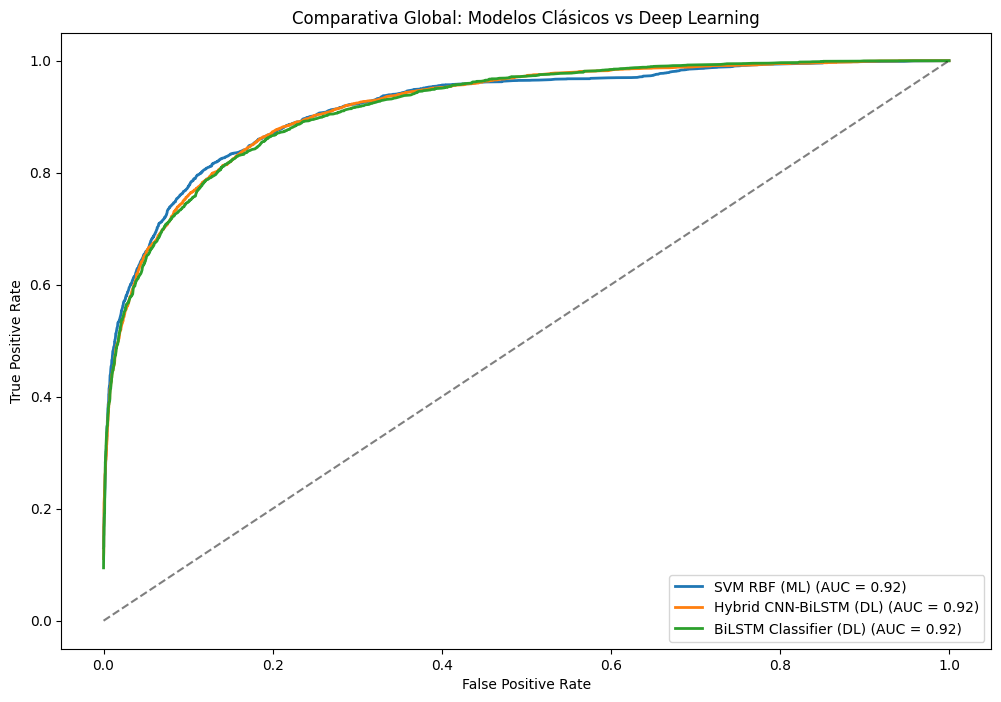

In [ ]:

config_global = [
    {
        'name': 'SVM RBF (ML)',
        'type': 'sklearn',
        'path': 'results/experiments/SVM_RBF_Smote/SVM_RBF_Smote_model.joblib',
        'X_test': X_test 
    },
    {
        'name': 'Hybrid CNN-BiLSTM (DL)',
        'type': 'torch',
        'path': 'data/experiments/Hybrid_CNN_BiLSTM_V7/best_model.pth',
        'class': HybridCNNBiLSTM,
        'params': {
            'vocab_size': len(vocab), 'embed_dim': 128, 'n_filters': 100, 
            'filter_sizes': [3, 4, 5], 'hidden_dim': 32, 'output_dim': df_nn['label_idx'].nunique()
        },
        'dataset': JournalDataset(test_df['processed_text'], test_df['label_idx'], vocab)
    },
    {
        'name': 'BiLSTM Classifier (DL)',
        'type': 'torch',
        'path': 'data/experiments/BiLSTM_Simple_V7/best_model.pth',
        'class': BiLSTMClassifier,
        'params': {
            'vocab_size': len(vocab), 'embed_dim': 128,
            'hidden_dim': 128, 'output_dim': df_nn['label_idx'].nunique()
        },
        'dataset': JournalDataset(test_df['processed_text'], test_df['label_idx'], vocab)
    }
]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

plot_unified_roc(config_global, test_df['label_idx'].values, device=device)